In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tslearn.utils import to_time_series_dataset
import re
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

In [2]:
# choose 113_PV_1 and 122_WIND_1


class WINDPV:
    def __init__(self, dispatch_data, LMP_data, wind_data, pv_data, metric, years, wind_gen, pv_gen):
        '''
        Initializes the bidder object.

        Arguments:
            dispatch_data: csv files with the dispatch power data

            wind_data: csv files with wind profile

            pv_data: csv files with pv profile

            metric: distance metric (“euclidean” or “dtw”).

            years: The size for the clustering dataset.

            wind_gen: name of wind generator

            pv_gen: name of pv generator

        Return:
            None
        '''
        self.dispatch_data = dispatch_data
        self.LMP_data = LMP_data
        self.wind_data = wind_data
        self.pv_data = pv_data
        self.metric = metric
        self.years = int(years)
        self.wind_gen = wind_gen
        self.pv_gen = pv_gen

        # make a dict key = generator name, value = pmax
        _wind_gen_pmax = {}
        _wind_gen_name = ['309_WIND_1', '317_WIND_1', '303_WIND_1', '122_WIND_1']
        _win_gen_pmax_list = [148.3, 799.1, 847, 713.5]
        _pv_gen_pmax = {}
        _pv_gen_name = ['320_PV_1', '314_PV_1', '314_PV_2', '313_PV_1', '314_PV_3', '314_PV_4', '313_PV_2',\
                       '310_PV_1', '324_PV_1', '312_PV_1', '310_PV_2', '324_PV_2', '324_PV_3', '113_PV_1',\
                       '319_PV_1', '215_PV_1', '102_PV_1', '101_PV_1', '102_PV_2', '104_PV_1', '101_PV_2',\
                       '101_PV_3', '101_PV_4', '103_PV_1', '119_PV_1']
        _pv_gen_pmax_list = [51.6, 51.6, 51.6, 95.1, 92.7, 51.6, 93.3,\
                            51.7, 49.7, 94.1, 51.6, 51.6, 51, 93.6,\
                            188.2, 125.1, 25.6, 25.9, 25.3, 26.8, 26.7,\
                            26.2, 25.8, 61.5, 66.6]

        for name, pmax in zip(_wind_gen_name, _win_gen_pmax_list):
            _wind_gen_pmax[name] = pmax

        for name, pmax in zip(_pv_gen_name, _pv_gen_pmax_list):
            _pv_gen_pmax[name] = pmax

            
        # check the wind generator and pv generator name are correct.
        # Assign pmax accroding to generators.
        if self.wind_gen in _wind_gen_name:
            self.wind_gen_pmax = _wind_gen_pmax[self.wind_gen]
        else:
            raise NameError("wind generator name {} is invaild.".format(self.wind_gen))

        if self.pv_gen in _pv_gen_name:
            self.pv_gen_pmax = _pv_gen_pmax[self.pv_gen]
        else:
            raise NameError("PV generator name {} is invaild.".format(self.wind_gen))       

    def read_input_pmax(self):

        '''
        read the input p_max for each simulation year

        Arguments:
            None

        Return:
            None
        '''

        input_data = 'prescient_generator_inputs.h5'
        df_input_data = pd.read_hdf(input_data)

        # first column is the p_max, from run_0 to run_64799
        df_pmax = df_input_data.iloc[:,1]
        pmax = df_pmax.to_numpy(dtype = float)
        self.pmax = pmax
        
        return
            
    def read_data(self):

        '''
        read clustering data from dispatch csv files
        
        Aruguments:
            None

        Return: 
            numpy array with dispatch data.
        '''

        ### to save time, need to modify to code to only read the target lines 
        df_dispatch = pd.read_csv(self.dispatch_data, nrows = self.years)
        df_LMP = pd.read_csv(self.LMP_data, nrows = self.years)

        # drop the first column
        df_dispatch_data = df_dispatch.iloc[: , 1:]
        df_LMP_data = df_LMP.iloc[: , 1:]

        # the first column is the run_index. Put them in an array
        df_index = df_dispatch.iloc[:,0]
        run_index = df_index.to_numpy(dtype = str)

        # In csv files, every run is not in sequence from 0 to 64999. 
        # run indexs are strings of 'run_xxxx.csv', make xxxx into a list of int
        self.index = []
        for run in run_index:
            index_num = re.split('_|\.',run)[1]
            self.index.append(int(index_num))

        # transfer the data to the np.array, dimension of test_years*8736(total hours in one simulation year)
        dispatch_array = df_dispatch_data.to_numpy(dtype = float)
        LMP_array = df_LMP_data.to_numpy(dtype = float)
        
        
        return dispatch_array, LMP_array
    
    def scale_data(self, dispatch_array):
        dispatch_years = dispatch_array[0:self.years]
        dispatch_years_index = self.index[0:self.years]
        scaled_dispatch = []
        for year,idx in zip(dispatch_years, dispatch_years_index):
            # scale by the p_max
            pmax_of_year = self.pmax[idx]
            scaled_year = year/pmax_of_year
            scaled_dispatch.append(scaled_year)
        return scaled_dispatch

    def read_wind_pv_data(self):

        '''
        length of wind and pv data is 366*24 = 8784 (366 days including Feb 29)
        length of dispatch data is 364*24 = 8736 (364 days, without Jan 1 and Dec 31)
        exclude first and last 24 time points in wind and pv data.
        '''
        wind_file = self.wind_data
        pv_file = self.pv_data

        total_wind_profile = pd.read_csv(wind_file)
        total_pv_profile = pd.read_csv(pv_file)
        selected_wind_data = total_wind_profile[self.wind_gen].to_numpy()
        selected_pv_data = total_pv_profile[self.pv_gen].to_numpy()

        # exclude Jan 1 and Dec 31
        # scale data by pmax to get capacity factors
        selected_wind_data = selected_wind_data[24:8760]/self.wind_gen_pmax
        selected_pv_data = selected_pv_data[24:8760]/self.pv_gen_pmax
        
#         joint_wind_pv = []
#         time_len = 24
#         day_num = int(len(selected_wind_data)/time_len)
#         for i in range(day_num):
#             joint_wind_pv.append([selected_wind_data[i*24:(i+1)*24], selected_pv_data[i*24:(i+1)*24]])
#         # print(np.shape(joint_wind_pv))
        return selected_wind_data, selected_pv_data


    def dispatch_visualize(self, scaled_dispatch_array, selected_wind_data, year_idx = 0):
        selected_year = scaled_dispatch_array[year_idx]
        f,axs = plt.subplots(4,3, figsize = ((24,18)))
        i = 0
        for j in range(4):
            for k in range(3):
                axs[j,k].scatter(selected_wind_data[i*720:(i+1)*720], selected_year[i*720:(i+1)*720])
                i += 1
                axs[j,k].set_xlabel('122_wind_1 capacify factor')
                axs[j,k].set_ylabel('123_steam_3 capacify factor')
                axs[j,k].set_ylim(-0.1,1.1)
                axs[j,k].set_xlim(-0.1,1.1)
        fig, ax = plt.subplots(figsize = ((9,6)))
        ax.scatter(selected_wind_data, selected_year)
        ax.set_xlabel('122_wind_1 capacify factor')
        ax.set_ylabel('123_steam_3 capacify factor')
        ax.set_ylim(-0.1,1.1)
        ax.set_xlim(-0.1,1.1)
        ax.set_title('LMP vs wind capacity factor in run_{}'.format(self.index[year_idx]))
        return
    
    def LMP_visualize(self, LMP_array, selected_wind_data, year_idx = 0):
        selected_year = LMP_array[year_idx]
        for i, j in enumerate(selected_year):
            if j >= 200:
                selected_year[i] = 200
        # plot by month
        f,axs = plt.subplots(4,3, figsize = ((24,18)))
        c = 0
        for j in range(4):
            for k in range(3):
                axs[j,k].scatter(selected_wind_data[c*720:(c+1)*720], selected_year[c*720:(c+1)*720])
                c += 1
                axs[j,k].set_xlabel('122_wind_1 capacify factor')
                axs[j,k].set_ylabel('LMP/$/MW')
                axs[j,k].set_ylim(-10,210)
                axs[j,k].set_xlim(-0.1,1.1)

        fig, ax = plt.subplots(figsize = ((9,6)))
        ax.scatter(selected_wind_data, selected_year)
        ax.set_ylim(-10,210)
        ax.set_xlim(-0.1,1.1)
        ax.set_xlabel('122_wind_1 capacify factor')
        ax.set_ylabel('LMP/$/MW')
        ax.set_title('LMP vs wind capacity factor in run_{}'.format(self.index[year_idx]))
        return
    
    def wind_dispatch_LMP_3D(self, scaled_dispatch_array, LMP_array, selected_wind_data, year_idx = 0):
        select_dis = scaled_dispatch_array[year_idx]
        select_lmp = LMP_array[year_idx]
        for i, lmp in enumerate(select_lmp):
            if lmp >= 200:
                select_lmp[i] = 200
        fig = plt.figure(figsize = ((9,9)))
        ax = fig.add_subplot(projection='3d')
        for d,l,w in zip(select_dis, select_lmp, selected_wind_data):
            ax.scatter(d, w, l)
        ax.set_xlabel('dispatch capacity factor')
        ax.set_ylabel('wind capacity factor')
        ax.set_zlabel('LMP')
        return

In [3]:
dispatch_data = 'Dispatch_shuffled_data_0.csv'
wind_data = 'DAY_AHEAD_wind.csv'
LMP_data = 'LMP_shuffled_data_0.csv'
pv_data =  'DAY_AHEAD_pv.csv'
metric = 'euclidean'
years = 100
pv_gen = '113_PV_1'
wind_gen = '122_WIND_1'

task = WINDPV(dispatch_data, LMP_data, wind_data, pv_data, metric, years, wind_gen, pv_gen)
task.read_input_pmax()
dispatch_data, LMP_data = task.read_data()
wind_data, pv_data = task.read_wind_pv_data()
# task.dispatch_visualize(dispatch_data, wind_data)
# task.LMP_visualize(LMP_data, wind_data)
# LMP_data[0][:720]

In [4]:
scaled_data = task.scale_data(dispatch_data)
print('Average capacify factor of random 100 parameter sweep simulations of 123_STEAM_3')
for idx, yr, i in zip(task.index, scaled_data, range(len(scaled_data))):
    print(f'{i}, run_{idx}:', sum(yr)/8736)
    
# from the results, we choose a high dispatch year: run_5707 (0.83), a medium dispatch year, run_42365(0.49) and a low
# dispatch year, run_37916 (0.15)

Average capacify factor of random 100 parameter sweep simulations of 123_STEAM_3
0, run_54242: 0.6454205630436458
1, run_5707: 0.8334245894871937
2, run_33622: 0.26323158540603614
3, run_44247: 0.8078031891709037
4, run_50261: 0.6597043552786563
5, run_31734: 0.8025862182711452
6, run_24288: 0.6215855298986225
7, run_12896: 0.004022898842413455
8, run_57587: 0.780499323465924
9, run_24855: 0.0007182921245421245
10, run_43044: 0.1456009546587252
11, run_48794: 0.8399533345351096
12, run_59729: 0.3151700543977541
13, run_5545: 0.8464042156490381
14, run_6418: 0.7681967224465397
15, run_32535: 0.6842681715288889
16, run_9562: 0.8435588265435628
17, run_27321: 0.8451862495133264
18, run_37211: 0.6489337760357128
19, run_4805: 0.8290510728425908
20, run_56865: 0.7978009103552952
21, run_38812: 0.016148213396404064
22, run_5089: 0.7944058461349278
23, run_21780: 0.827847971814842
24, run_35733: 0.8165214221357919
25, run_12748: 5.151098901098901e-05
26, run_28317: 0.7479454937857696
27, run_

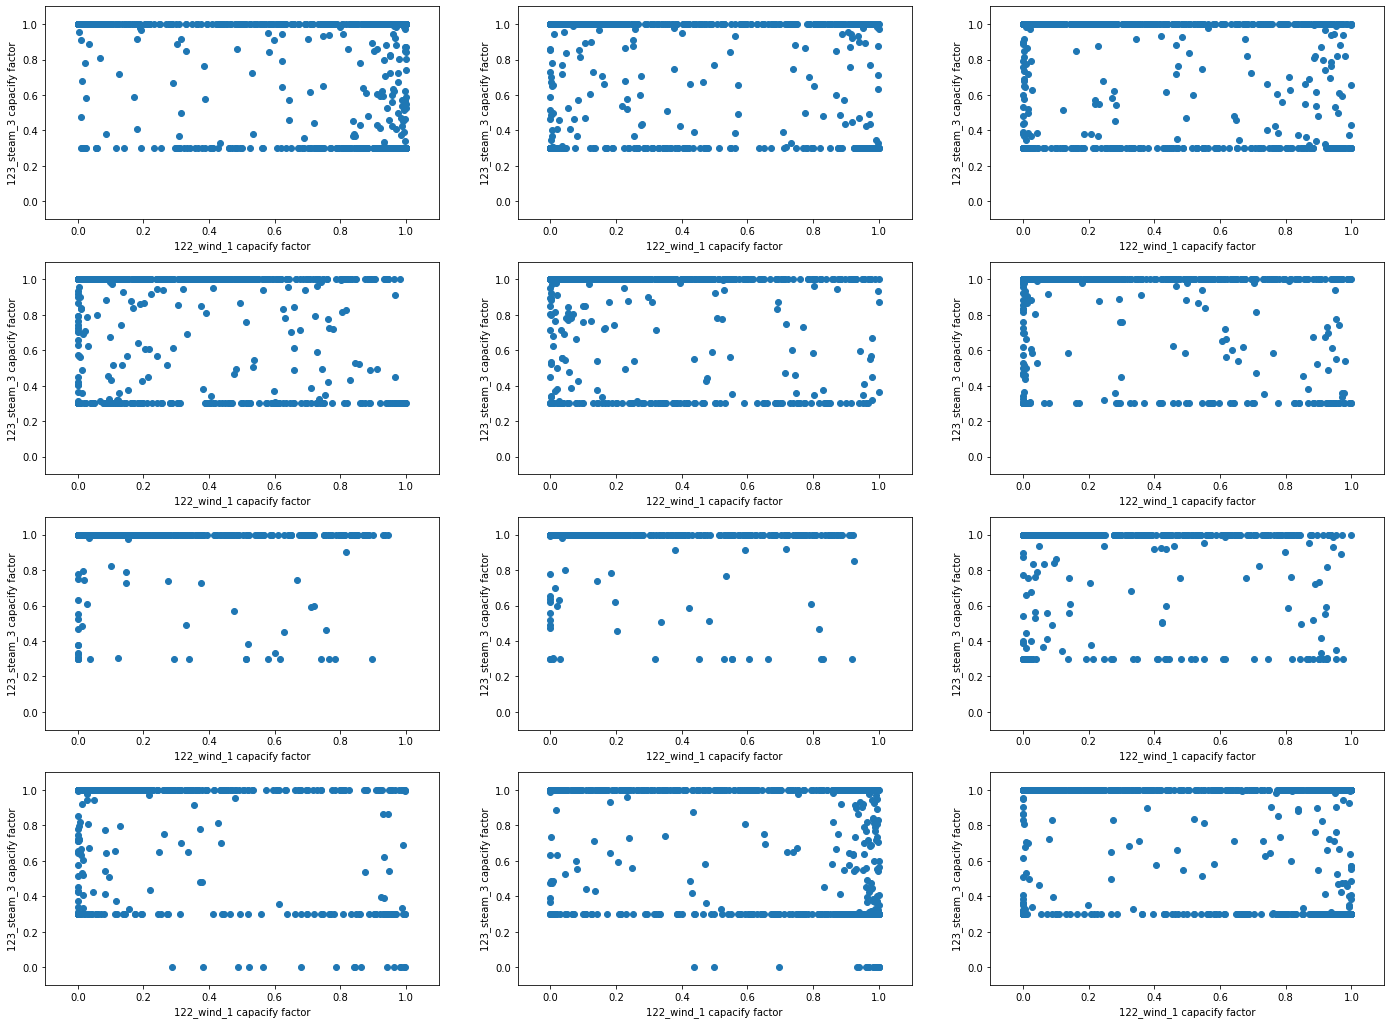

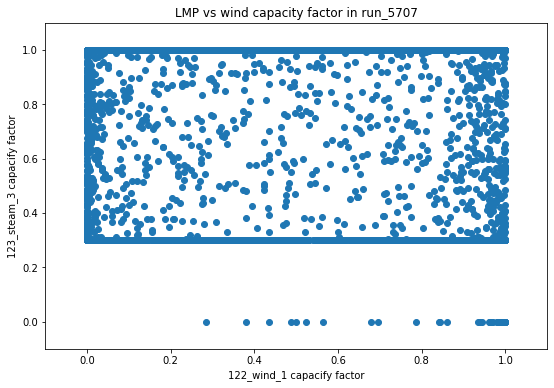

In [23]:
# high dispatch / wind vs dispatch
task.dispatch_visualize(scaled_data, wind_data, year_idx = 1)

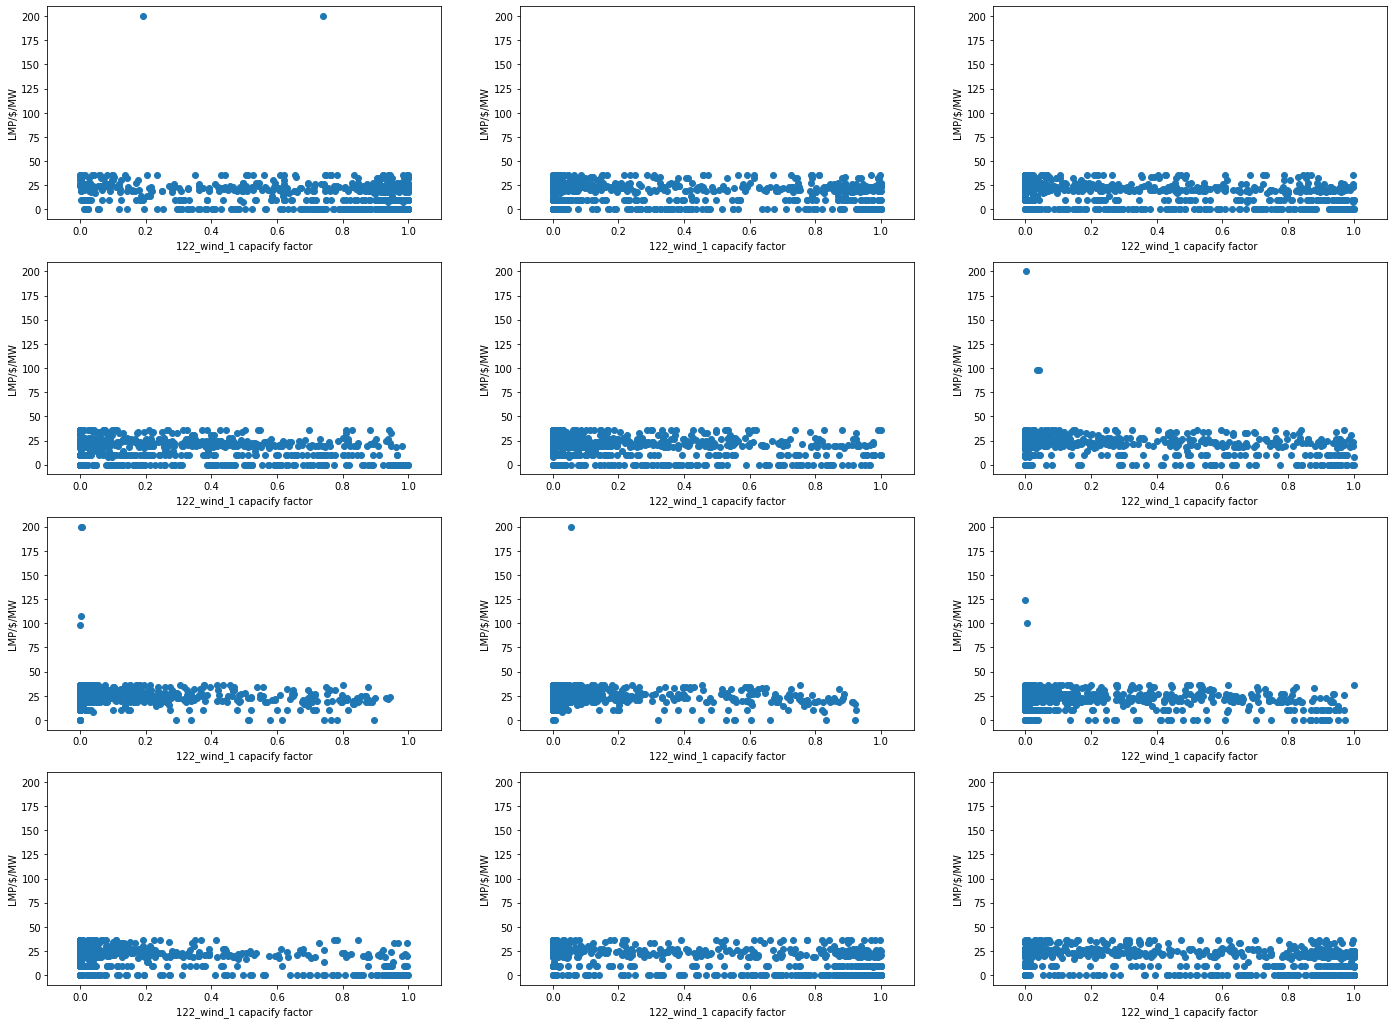

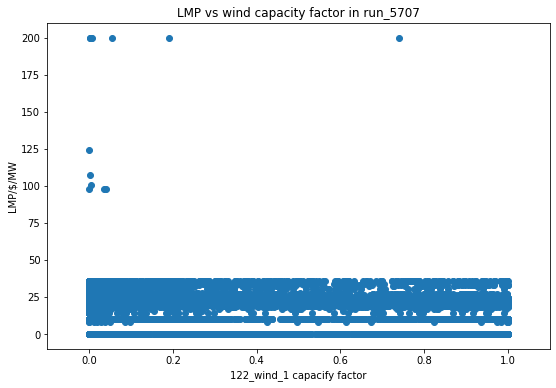

In [24]:
# high dispatch / wind vs LMP
task.LMP_visualize(LMP_data, wind_data, year_idx = 1)

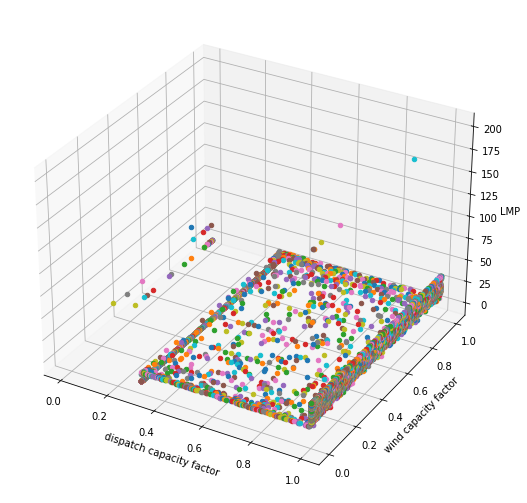

In [27]:
# high dispatch, 3D
task.wind_dispatch_LMP_3D(scaled_data, LMP_data, wind_data, year_idx = 1)

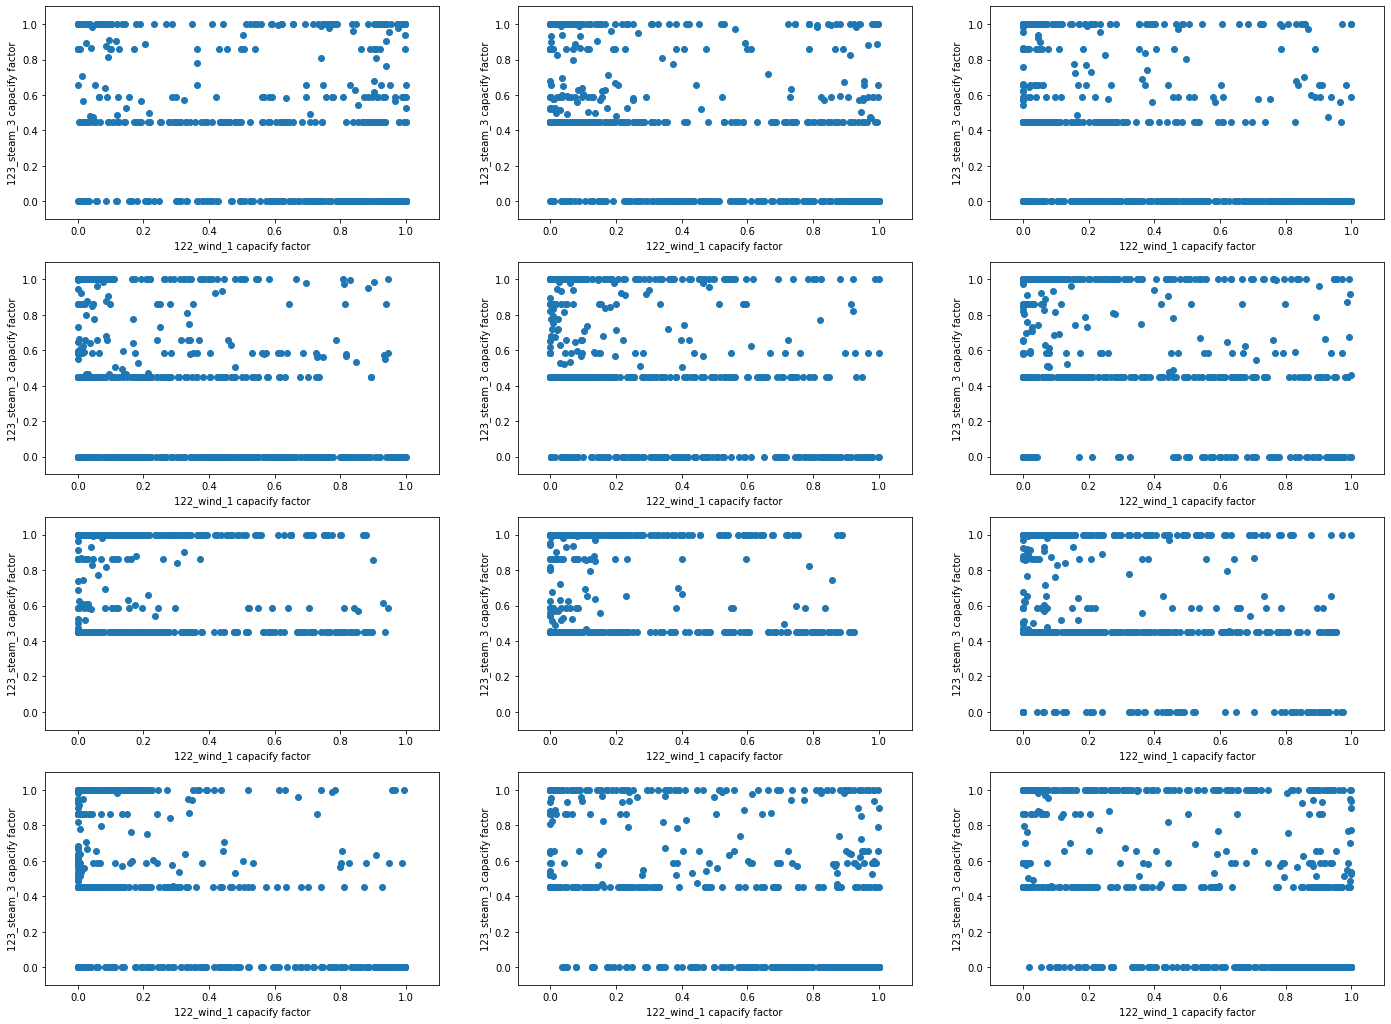

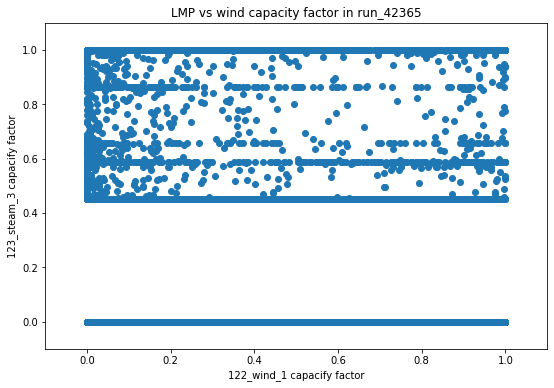

In [26]:
# medium dispatch / wind vs dispatch
task.dispatch_visualize(scaled_data, wind_data, year_idx = 67)

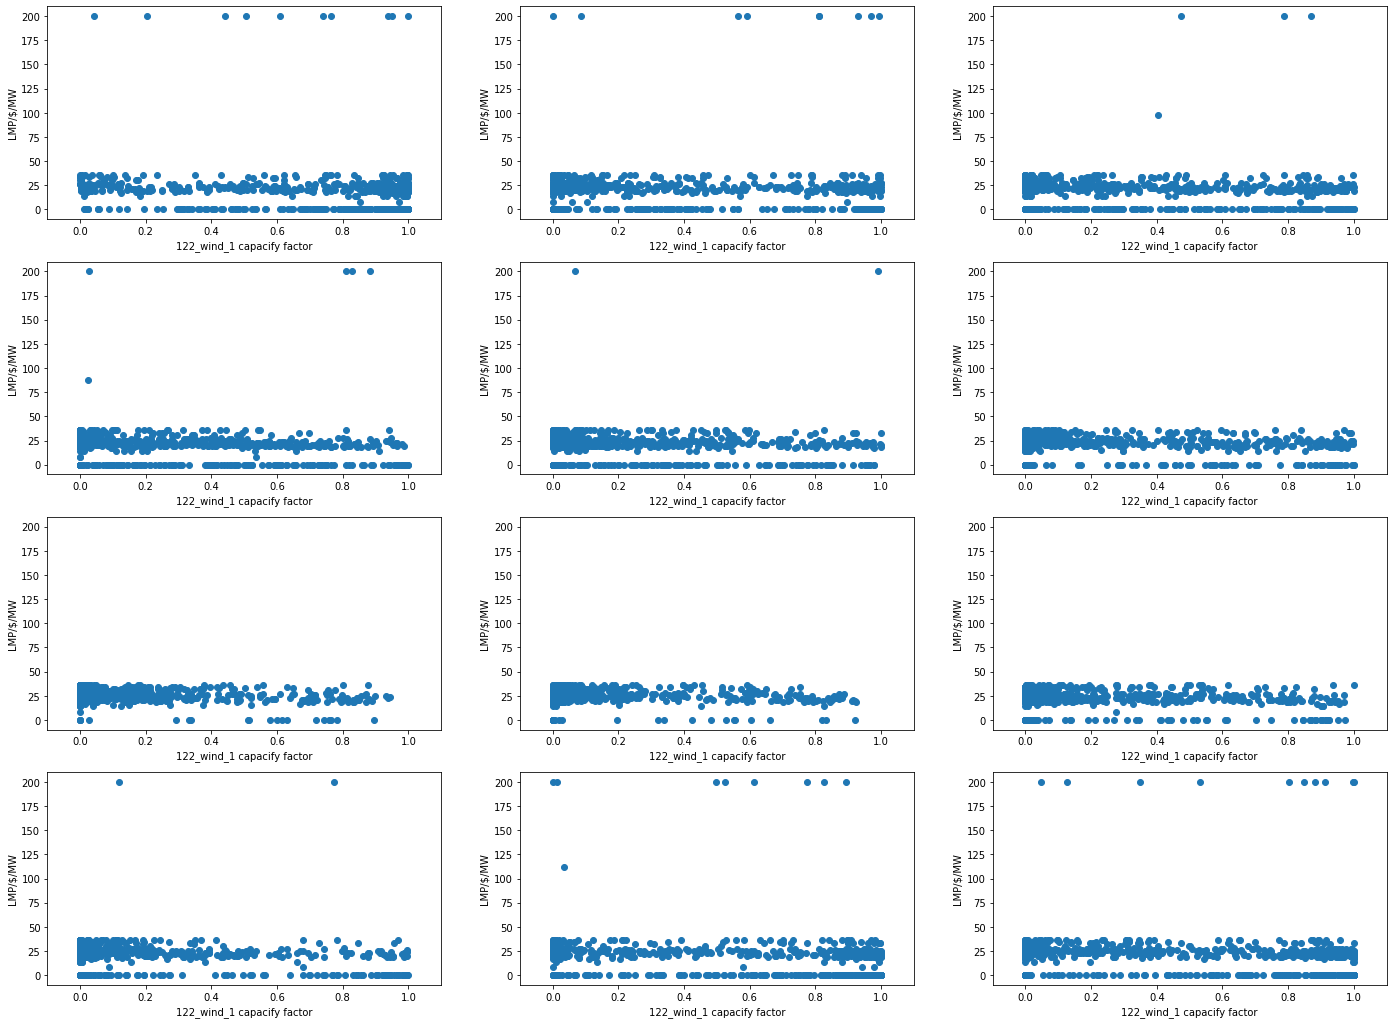

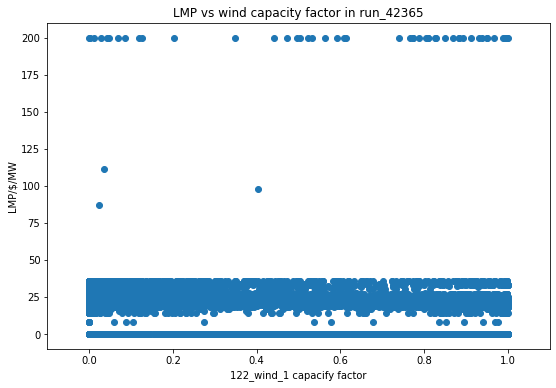

In [101]:
# medium dispatch / wind vs LMP
task.LMP_visualize(LMP_data, wind_data, year_idx = 67)

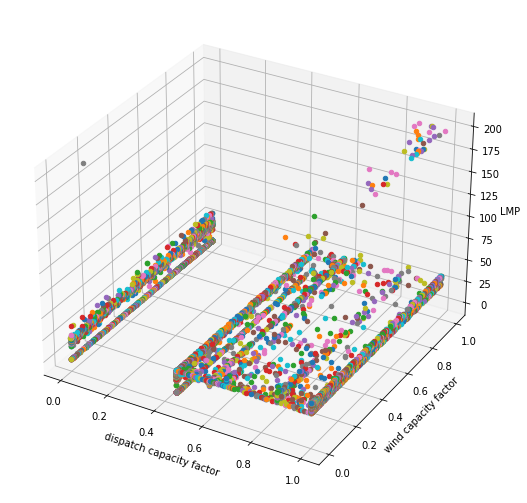

In [28]:
# medium dispatch, 3D
task.wind_dispatch_LMP_3D(scaled_data, LMP_data, wind_data, year_idx = 67)

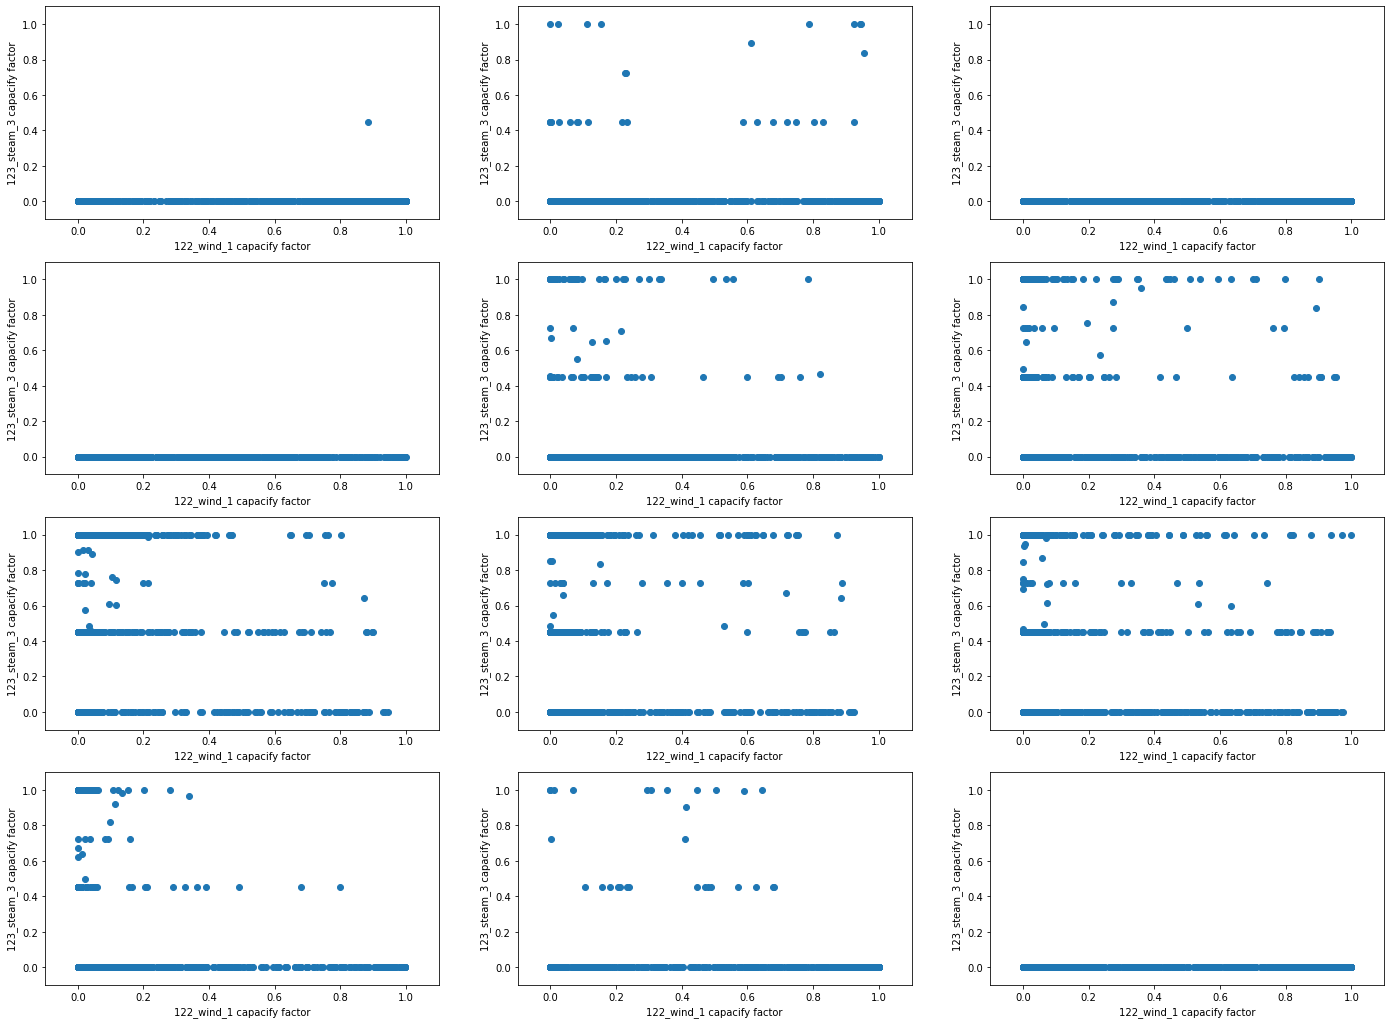

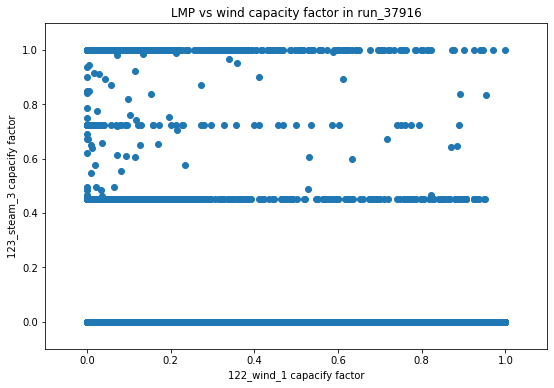

In [102]:
# low dispatch / wind vs dispatch
task.dispatch_visualize(scaled_data, wind_data, year_idx = 91)

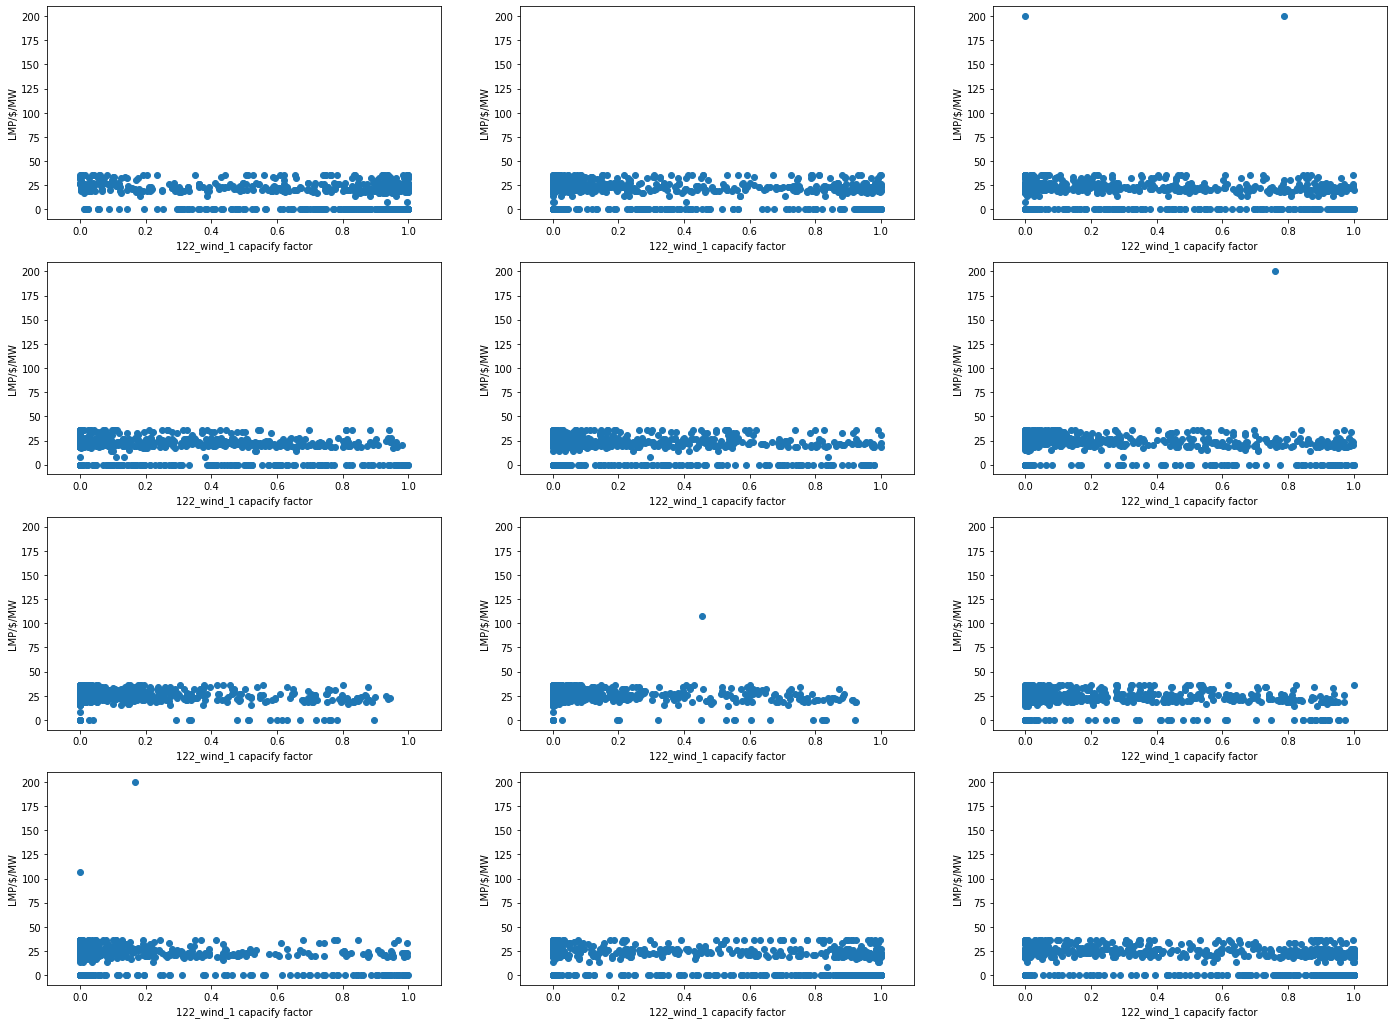

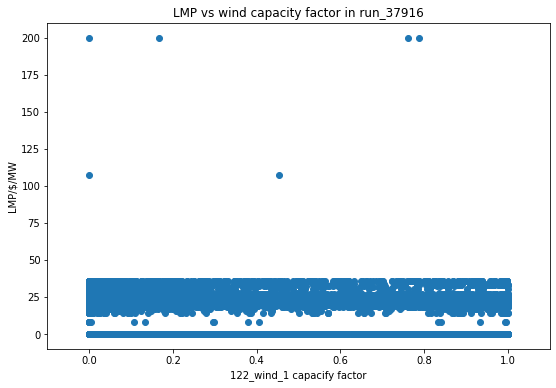

In [103]:
# low dispatch / wind vs LMP
task.LMP_visualize(LMP_data, wind_data, year_idx = 91)

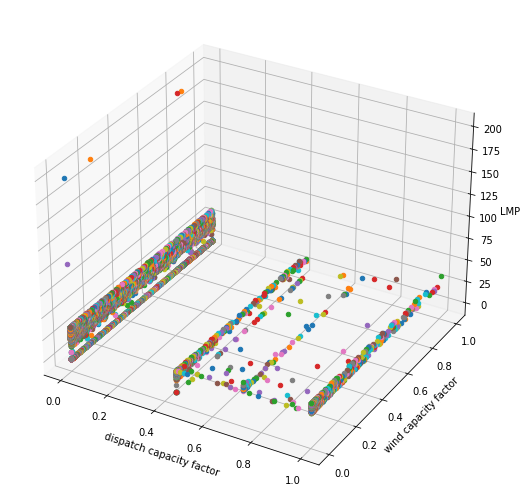

In [29]:
task.wind_dispatch_LMP_3D(scaled_data, LMP_data, wind_data, year_idx = 91)

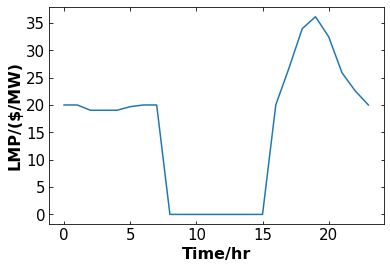

In [12]:
plt.plot(range(24), LMP_data[0][72:96])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Time/hr',fontsize=16,fontweight='bold')
plt.ylabel('LMP/($/MW)',fontsize=16,fontweight='bold')
plt.tick_params(direction="in",top=True, right=True)
